# Exercise set 9

> * The goal of the first part of the exercise is to gain familiarity with partial least
squares regression. For this, we will make
a model that can predict the concentrations in a mixture from near-infrared spectra.
> 
> * In the second part of the exercise, you will do a PCA analysis of gene expressions.
This part is to get more experience with PCA, particularly interpreting results from PCA.

## Exercise 9.1

[Windig and Stephenson](https://doi.org/10.1021/ac00046a015) measured near-infrared spectra
for 140 mixtures of the solvents methylene chloride, 2-butanol, methanol,
dichloropropane, and acetone. Here, we will predict the compositions of the mixtures from the spectra.
Each spectrum was sampled at 700 wavelengths
between 1100 and 2500~nm. The file
[`Data/windig.csv`](Data/windig.csv) contains the raw data:
Each row in this file
contains a spectrum (the columns starting with `wavelength.`) and the
corresponding concentrations (the columns starting with `conc.`).

The data can be loaded as follows:

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline
sns.set_context("notebook")

data = pd.read_csv("Data/windig.csv")
X = data.filter(like="wavelength", axis=1).values  # NIR spectra
Y = data.filter(like="conc", axis=1).values  # Concentrations
print(f"No. of spectra: {X.shape[0]}")
print(f"No. of wavelengths: {X.shape[1]}")
print(f"No of concentration samples: {Y.shape[0]}")
print(f"No of species in each sample: {Y.shape[1]}")

C:\Users\joach\AppData\Local\Temp\ipykernel_3796\3686929923.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


No. of spectra: 140
No. of wavelengths: 700
No of concentration samples: 140
No of species in each sample: 5


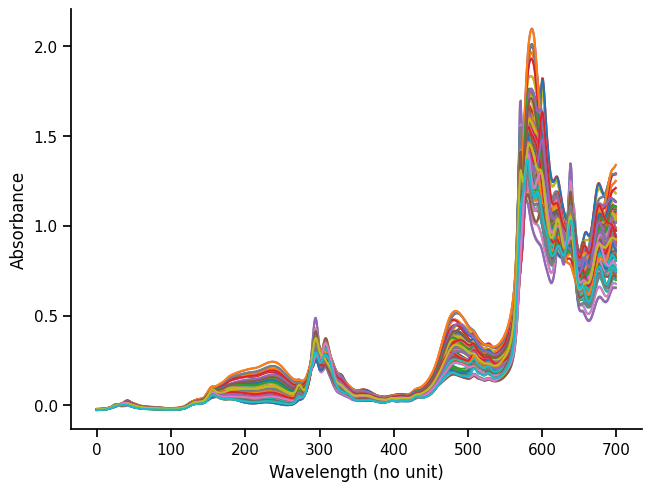

In [4]:
# To plot the spectra:
fig, ax = plt.subplots(constrained_layout=True)
for spectrum in X:
    ax.plot(spectrum)
ax.set(xlabel="Wavelength (no unit)", ylabel="Absorbance")
sns.despine(fig=fig)

### 9.1(a)
Create a partial least squares regression (PLSR) model for predicting
the concentrations. Use 1 PLS component for your first model and
assess it using $R^2$, RMSEC, RMSECV and RMSEP.  An example
of how this can be done are given below.

These values (RMSEC, RMSECV, and RMSEP) are all based on calculating the
root mean squared error (RMSE) given by,

\begin{equation}
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^N (y_i - \hat{y}_i)^2},
\tag{1}\end{equation}

where $y_i$ are our measured $y$-values and $\hat{y}_i$ are the
values predicted by our model. The difference between RMSEC,
RMSEP, and RMSECV lie in the part of the data we use to
calculate them. This is based on first splitting the data into
a *training* and *test* set, and then
performing what we call
[*cross-validation*](https://scikit-learn.org/stable/modules/cross_validation.html) using
the training set:


* When we use the training set to create our model, we are doing
  a *calibration*. If we calculate RMSE based on using
  the training set, we refer to this as the RMSEC (root mean squared
  error of calibration).
  This number
  quantifies the error we get in connection with making (calibrating)
  the model.
  
* When we use the test set to test our model, we are
  checking how well our model *predicts* "new" samples
  (that is, samples not used when making the model). If
  we calculate RMSE based on the training set, we refer to 
  this as the RMSEP (root mean squared error of prediction). This
  number quantifies the error we can expect to make when using
  our model for predicting new samples.
  
* Cross-validation is based on further splitting the training set. Typically, we divide the
  training set into $k$ smaller subsamples, and we repeat the fitting of the
  model $k$ times. Each time we repeat the fitting, we retain a single
  subsample for validation, and we fit the model using
  the $k-1$ other subsamples. For the subsample we retained
  for validation, we can calculate the RMSE value of how
  well our model predicts it. Since we repeat this $k$ times,
  we can make it so that each of the $k$ subsamples is
  used exactly once for validation. Finally, we can
  obtain the average RMSE of the $k$ fittings, and we
  refer to this value as the RMSECV (root mean squared error
  of cross-validation). This number also estimates how well the model predicts new cases, and   we also get information on how sensitive the model is to model parameters and the part of   
  the training set used. We can also use cross-validation to optimize the parameters in the 
  model (for instance, the number of PLS components).

Luckily, methods for splitting our data into training and test
sets, calculating RMSE, and doing cross-validation are already
available in sklearn. Note: Splitting the data into training
and test sets and performing cross-validation involves some randomness, and your answers will probably change if you rerun
your code.

Here is a visualization of the splitting:
![cross](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [5]:
# First, here is how you can split into a testing and training set:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.33,  # Use 33 % of the data (one third) for the test set.
    shuffle=True,  # Randomly shuffle the data
)

In [6]:
# Make a PLS model:
from sklearn.cross_decomposition import PLSRegression

model = PLSRegression(n_components=4)  # Set up a PLS model with 4 components
model.fit(X_train, Y_train)  # Fit/make the model

PLSRegression(n_components=4)

In [7]:

# Calculate scores for the model:
from sklearn.metrics import mean_squared_error, r2_score

Y_hat_train = model.predict(X_train)  # Predict for the training set
Y_hat_test = model.predict(X_test)  # Predict for the test set

# Calculate R²:
r2_train = r2_score(Y_train, Y_hat_train) #gives the r2 for the model fitted to the predicted values vs the ones used to create the model (?)
print(f"R² for training set: {r2_train}")
r2_test = r2_score(Y_test, Y_hat_test)
print(f"R² for test set: {r2_test}")

# Calculate RMSE:
rmsec = mean_squared_error(Y_train, Y_hat_train, squared=False) # error of calibration (creating the model)
print(f"RMSEC: {rmsec}")
rmsep = mean_squared_error(Y_test, Y_hat_test, squared=False) # error in prediction (predicted vs actual data)
print(f"RMSEP: {rmsep}")

# rmsec = 2.124
# rmsep = 2.844
# what are considered good values?
# the values are based on difference between measured and predicted values so I assume a lower value is better, but what is the threshhold for good/bad?
print(r2_train)

R² for training set: 0.9485378774051124
R² for test set: 0.9543774606068949
RMSEC: 2.255908698711423
RMSEP: 2.3881911240122546
0.9485378774051124


c:\Coding\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Coding\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [8]:
# Example for cross-validation:
from sklearn.model_selection import cross_val_score

# Run cross-validation:
cvscore = cross_val_score(
    model,  # Select the model we are going to score
    X_train,  # Give the X-training set
    Y_train,  # Give the y-training set
    scoring="neg_mean_squared_error",  # select scoring method
    cv=5,  # Number of splits to make
)
# Note: the scoring is here "neg_mean_squared_error".
# This is the negative of the MSE!
# The cross_val_score method is often used in
# connection with optimization where we would like to
# maximize something, and the score can be used to pick
# the best value. Since we usually do not want to
# maximize the error, this method is made so that it
# calculates the negative of the error.

cvscore = np.sqrt(-cvscore)  # Account for the negative sign.
rmsecv = cvscore.mean()
rmsecv_std = np.std(cvscore)
print(f"\nRMSECV: {rmsecv} ± {rmsecv_std}")
# rmsecv = 2.724 +- 0.319, again, what are considered good values?


RMSECV: 2.851432573872701 ± 0.4645771158614782


Create a partial least squares regression (PLSR) model for predicting
the concentrations. Use 1 PLS component for your first model and
assess it using $R^2$, RMSEC, RMSECV and RMSEP.

In [58]:
# Your code here
# Use X (wavelength) and Y (cocentrations) as defined previously
# splitting into test and training sets for X and Y (train_test_split)
# PLS model (PLSRegression(n_components = 1))
# fit the model to the training data ('fasiten') (PLSRegresson.fit(X_trainingdata, Y_training data))
# create prediction for the training ('fasit') and test data (model.predict(train/test))
# r2 value for actual train data vs predicted train values (same for test)

# splitting both wavelengths and concentrations into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.33, 
    shuffle=True, 
)

# creating model from training data with 1 component
model1component = PLSRegression(n_components = 1)
model1component.fit(X_train, Y_train) # fit the model to the training data

# create prediction for both training and testing data from the model
predictYtrain = model1component.predict(X_train) # predicts Y values (concentrations) from X-values (wavelengths) in the training set
predictYtest = model1component.predict(X_test) # predicts Y values (concentrations) from X-values (wavelengths) in the test set

# R2 values for prediction on training set and test set
r2_train = r2_score(Y_train, predictYtrain)
r2_test = r2_score(Y_test, predictYtest)
print(f"R2 for training set is {r2_train:.5f}\nR2 for test set is {r2_test:.5f}")

#RMSEs for test (prediction/ rmsep) and training (calibraion/rmsec) set
rmsec = mean_squared_error(Y_train, predictYtrain, squared = False) # calibration, training set
rmsep = mean_squared_error(Y_test, predictYtest, squared = False) #prediction, test data
# why use prediction = False?

print(f"RMSEC = {rmsec:.5f}\nRMSEP = {rmsep:.5f}")

# cross validate: cross_validate(model, X(data to fit(wavelength)), Y(variable to predict(concentration)), return_train_score)
# or cross_val_score? what is the difference?

cv = cross_val_score(
                    model1component,
                    X_train, Y_train, 
                    scoring = "neg_mean_squared_error",
                    cv=5  # Why 5 splits
)
cv = np.sqrt(-cv)
rmsecv = cv.mean()
rmsecv_std = cv.std()

print(f"RMSECV = {rmsecv:.5f} \u00B1 {rmsecv_std:.5f}")

print(len(Y_train), len(predictYtrain))

R2 for training set is 0.24831
R2 for test set is 0.13503
RMSEC = 10.22897
RMSEP = 11.15444
RMSECV = 10.60337 ± 0.28545
93 93


c:\Coding\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Coding\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Your answer to question 9.1(a): ($R^2$, RMSEC, RMSECV and RMSEP)

The R2 values for the test and training set of the 1-component model 

R2 for training set: 0.24054\
R2 for test set: 0.21081

were much lower than that of the 4-component model

R² for training set: 0.96062\
R² for test set: 0.87752.


While the RMSEs for the 1-component model

RMSEC: 10.67010\
RMSEP: 10.14313\
RMSECV: 11.10380 ± 0.81088

were much higher than that of the 4-component model

RMSEC: 2.12474\
RMSEP: 2.84383\
RMSECV: 2.72416 ± 0.31877.

The lower R2 and higher RMSEs indicate that the 1-component model is a very poor representation of the data.

### 9.1(b)
Improve your PLSR model by including more
PLS components.
Try components from 2 up to 15 and compare the different models. How many
PLS components are you satisfied with? 

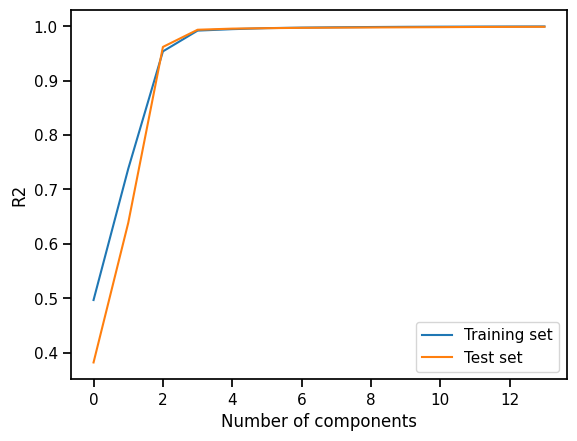

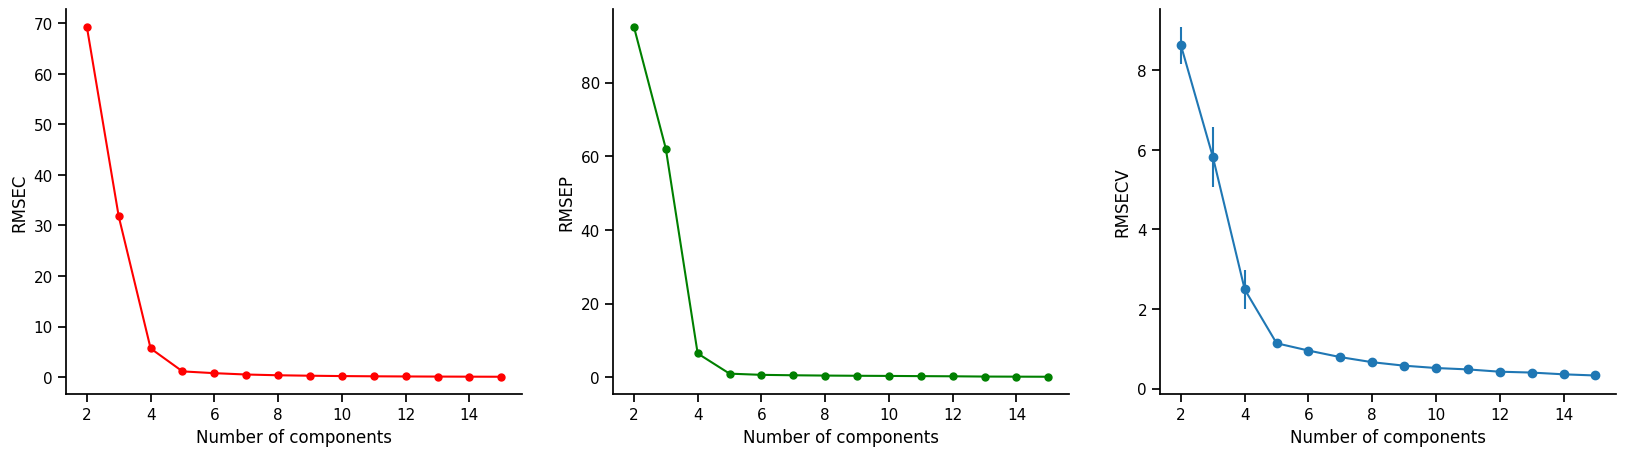

In [60]:
# Your code here

# create k models (2, 15 components) and compare (r2 and rmse (?))
models = []
for i in range(2, 16):
    models.append(PLSRegression(n_components = i))
for i in range(len(models)):
    models[i].fit(X_train, Y_train)

predict_i_Y_train = [model.predict(X_train) for model in models]
predict_i_Y_test = [model.predict(X_test) for model in models]

# r2 values
r2Train = []
r2Test = []

for prediction in predict_i_Y_train:
    r2Train.append(r2_score(Y_train, prediction))
    
for prediction in predict_i_Y_test:
    r2Test.append(r2_score(Y_test, prediction))
    

fig, ax = plt.subplots()

ax.plot(r2Train, label = "Training set")
ax.plot(r2Test, label = "Test set")
ax.set_xlabel("Number of components")
ax.set_ylabel("R2")
plt.legend()
    
# rmse
RMSECs = []
for model in predict_i_Y_train:
    RMSECs.append(mean_squared_error(Y_train, model))
RMSEPs = []
for model in predict_i_Y_test:
    RMSEPs.append(mean_squared_error(Y_test, model))
RMSECVs = []
RMSECVs_std = []
for model in models:
    cvs = cross_val_score( # could use cross_validate() to do both rmsecv and r2(?)
        model,
        X_train,
        Y_train,
        scoring = "neg_mean_squared_error",
        cv = 5
    )
    score = np.sqrt(-cvs)
    RMSECVs.append(score.mean())
    RMSECVs_std.append(score.std())

xvals = np.arange(2,16)
fig, axs = plt.subplots(ncols = 3, figsize = (20,5))
axs[0].plot(xvals, RMSECs, "r", marker = ".", markersize = 10)
axs[0].set_xlabel("Number of components")
axs[0].set_ylabel("RMSEC")

axs[1].plot(xvals, RMSEPs, "g", marker = ".", markersize = 10)
axs[1].set_xlabel("Number of components")
axs[1].set_ylabel("RMSEP")
    
axs[2].errorbar(
    xvals,
    RMSECVs,
    yerr= RMSECVs_std,
    marker = "o",
)
axs[2].set_ylabel("RMSECV")
axs[2].set_xlabel("Number of components")
sns.despine()



# for model in predict_i_Y_test:
#     print(len(model))



    





#### Your answer to question 9.1(b):

It seems the model has little improvement after 5 components, and so this is the number I would use

### 9.1(c)
Plot the regression coefficients for the model you found in [9.1(b)](#9.1(b)).

In [ ]:
# You can get the regression coefficients with:
B = model.coef_
# To get the coefficients for solvent no. i, you can do:
# B[i, :]  # this selects all rows for column i.

In [112]:
# Your code here
optimalModel = models[3]
print(optimalModel)

B = optimalModel.coef_ # shape 5, 700: each row is a species in the sample, and each sample has 700 wavelength measured (coefficient for the wavelength on the species(?))
# Coefficients indicate the importance of each term (wavelength?) in determining the species in each sample/concentration ?



PLSRegression(n_components=5)
-0.013556734847662516


#### Your answer to question 9.1(c):
*Double click here*

### 9.1(d)
Optimize the number of PLS components by a cross-validated grid search of the number of
PLS components. Is this optimized model different from the PLS model you found in [9.1(b)](#9.1(b))?

In [113]:
# Here is the code for running the optimalization. This will try out
# the number of PLS components and score the model with cross validation.
from sklearn.model_selection import GridSearchCV

# First, we define a range of PLS components to try, let us
# do 1, 2, ..., 20, 25, 50, 75, 100:
parameters = {"n_components": list(range(1, 20)) + [25, 50, 75, 100]}

grid = GridSearchCV(
    PLSRegression(),  # the model we will make
    parameters,  # the parameters to investigate
    cv=5,  # number of splits for cross-validation
    scoring="r2",  # select the model with highest R²
    refit=True,  # refit the best model for the whole training set
)
grid.fit(X_train, Y_train)

c:\Coding\Lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 74
  warnings.warn(f"Y residual is constant at iteration {k}")
c:\Coding\Lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 74
  warnings.warn(f"Y residual is constant at iteration {k}")
c:\Coding\Lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 74
  warnings.warn(f"Y residual is constant at iteration {k}")
c:\Coding\Lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 74
  warnings.warn(f"Y residual is constant at iteration {k}")
c:\Coding\Lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is constant at iteration 74
  warnings.warn(f"Y residual is constant at iteration {k}")
c:\Coding\Lib\site-packages\sklearn\cross_decomposition\_pls.py:305: UserWarning: Y residual is

GridSearchCV(cv=5, estimator=PLSRegression(),
             param_grid={'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 25, 50,
                                          75, 100]},
             scoring='r2')

In [114]:
# The best estimator us:
grid.best_estimator_

PLSRegression(n_components=50)

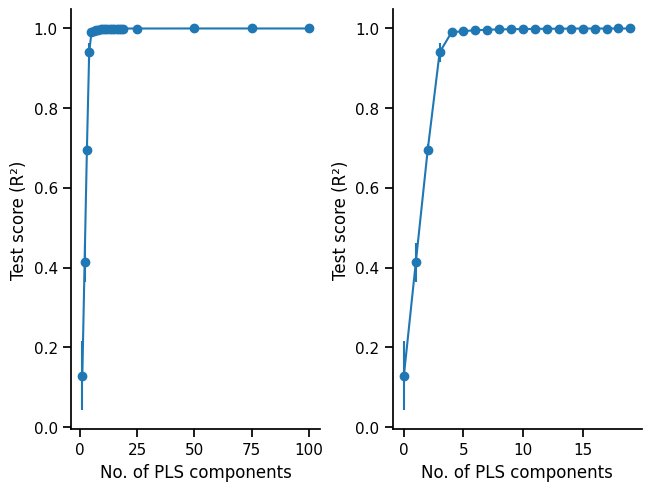

In [121]:
# It is also a good idea to plot the scores to see where it levels off:
fig, ax = plt.subplots(constrained_layout=True, ncols = 2)
ax[0].errorbar(
    parameters["n_components"],
    grid.cv_results_["mean_test_score"],
    yerr=grid.cv_results_["std_test_score"],
    marker="o",
)
ax[0].set(xlabel="No. of PLS components", ylabel="Test score (R²)")

ax[1].errorbar(
    np.arange(0, 20),
    grid.cv_results_["mean_test_score"][:20],
    yerr=grid.cv_results_["std_test_score"][:20],
    marker="o",
)
ax[1].set(xlabel="No. of PLS components", ylabel="Test score (R²)")
sns.despine(fig=fig)
# Hint: It may be a good idea to zoom in on the part (1, 20) for the x-axis:

#### Your answer to question 9.1(d):

I found that a model with 5 components would be optimal, and it seems the same is true here

### 9.1(e)
Assume that you are given a spectrum from a mixture with unknown concentrations of the solvents. How well would your model
predict the unknown concentrations?

In [ ]:
# Your code here

#### Your answer to question 9.1(e):

Jeg er usikker på hva for ventet svar er her?

Er dette et teoretisk spørsmål (mtp at det også er en blokk for egen kode)? Mtp at R2 er ganske høy og RMSEs er lav vil jeg anta at prediction er ganske bra


### 9.1(f)
Create a least squares model for predicting the concentrations.
Assess it using $R^2$, RMSEC, RMSECV and RMSEP. Does this model
perform as you expect?

In [ ]:
# Your code here
# Least squares with LinearRegression, model.fit()
# model.predict(x-values)
# r2_score(y, predicted y)

#### Your answer to question 9.1(f):
*Double click here*

## Exercise 9.2

[Schummer *et al.*](https://doi.org/10.1016/S0378-1119(99)00342-X) sstudied ovarian cancer by measuring gene expression values for 1536 genes in both non-cancer and cancer tissues. One of their goals was to investigate whether specific genes were overexpressed in cancer samples compared to non-cancer ones.
This knowledge may be used for diagnosis, and we will here see if we
can find such genes by performing a PCA. The raw data can be
found in the file [`Data/ovo.csv`](Data/ovo.csv).
Each row in the data file contains a tissue sample's gene expressions (for 1536 genes). Each column corresponds to a specific gene, named `X.1`, `X.2`, and so on.
The classification of tissue as non-cancer (`N`) or cancer (`C`) can
be found in the column `class`.

In [ ]:
"""Load the data set."""
import pandas as pd

data = pd.read_csv("Data/ovo.csv")
classes = data["class"]  # Classification of samples.
X = data.filter(like="X.", axis=1)  # Gene expressions for samples.

### 9.2(a)
 
Perform a principal component analysis (PCA) on the gene expression data
and plot the explained variance as a function of the number of components.

Center the data before performing the PCA. This can be
done as follows with the `scale` method
from `sklearn.preprocessing`:

```python
X = scale(X, with_std=False)
```
Here, all the variables are in the same units, so we do not need
to scale the variance (we set `with_std=False`).

In [ ]:
from sklearn.preprocessing import scale

X = scale(X, with_std=False)

In [ ]:
# Your code here

#### Your answer to question 9.2(a):
*Double click here*

### 9.2(b)
Inspect the data by plotting the scores and loadings for
principal component
number 1 and principal component number 2:


* (i) Can you observe any clustering
  of the samples? Here, it may be helpful to colour the samples
  according to their classification as non-cancer or cancer.


* (ii) Are there any outliers among the samples?


* (iii) Can you identify some overexpressed genes in cancer tissue? 


* (iv) Can you identify some underexpressed genes in cancer tissue?

In [ ]:
# Your code here

#### Your answer to question 9.2(b):
*Double click here*

### 9.2(c)
Based on your answer in [9.2(b)](#9.2(b)), can
you identify some pairs of genes that distinguish between
non-cancer and cancer tissues? Support your findings by plotting the raw data.

In [ ]:
# Your code here

#### Your answer to question 9.2(c):
*Double click here*